In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader as loader
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR, OneCycleLR
import matplotlib.pyplot as plt


In [157]:
transform=transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,),(0.5,))])

train_data=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_data=datasets.MNIST(root='./data', train=False,download=True,transform=transform)
train_loader=loader(train_data, batch_size=64, shuffle=True)
test_loader=loader(test_data, batch_size=1000,shuffle=True)



In [158]:
class Models(nn.Module):
    def __init__(self,dropout_p=3):
        super(Models,self).__init__()
        self.fc1=nn.Linear(28*28,256)
        self.drop=nn.Dropout(dropout_p)
        self.fc2=nn.Linear(256,10)

    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=torch.relu(self.fc1(x))
        x=self.drop(x)
        return self.fc2(x)

In [176]:
def train(
    model, optimizer, criterion,
    train_loader, test_loader,
    num_epoch, scheduler_fn, scheduler_name
):
    # 1) 결과 저장 리스트
    lr_list, val_list = [], []

    # 2) 스케줄러 인스턴스화
    if scheduler_name == "OneCycleLR":
        scheduler = scheduler_fn(
            optimizer,
            max_lr=0.1,
            total_steps=num_epoch * len(train_loader)
        )
    else:
        scheduler = scheduler_fn(optimizer)

    for epoch in range(1, num_epoch+1):
        # — 학습 단계 —
        model.train()
        total_acc = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            # OneCycleLR: 배치 단위로 step
            if scheduler_name == "OneCycleLR":
                scheduler.step()

            total_acc += (logits.argmax(1) == yb).sum().item()

        # 나머지 스케줄러: 에포크 단위로 step
        if scheduler_name != "OneCycleLR":
            scheduler.step()

        # 학습률 저장
        lr_list.append(optimizer.param_groups[0]['lr'])

        # — 검증 단계 —
        model.eval()
        correct = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb).argmax(1)
                correct += (pred == yb).sum().item()

        val_acc = correct / len(test_loader.dataset)
        val_list.append(val_acc)

        print(f"Epoch {epoch}: lr={lr_list[-1]:.5f}, val_acc={val_acc:.4f}")

    return lr_list, val_list


In [187]:
device=torch.device('cuda'if torch.cuda.is_available()else'cpu')
num_epoch=10
'''
scheduler={
    'StepLR':lambda optimy:StepLR(optimy, step_size=3, gamma=0.5),
    'ExponentialLR':lambda optimy:ExponentialLR(optimy,gamma=0.5),
    'CosineAnnealingLR':lambda optimy:CosineAnnealingLR(optimy,T_max=num_epoch,eta_min=1e-3),
    'OneCycleLR':lambda optimy:OneCycleLR(
        optimy,
        max_lr=0.1,
        total_steps=num_epoch * len(train_loader)  # 배치 단위 스텝 수
    )
}
'''
scheduler = {
    'StepLR'           : lambda opt: StepLR(opt, step_size=3, gamma=0.5),
    'ExponentialLR'    : lambda opt: ExponentialLR(opt, gamma=0.5),
    'CosineAnnealingLR': lambda opt: CosineAnnealingLR(opt, T_max=num_epoch, eta_min=1e-3),
    'OneCycleLR'       : OneCycleLR     # ← 람다가 아니라 클래스 참조
}


In [189]:
model=Models(dropout_p=0.1).to(device)
optimy=optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criter=nn.CrossEntropyLoss()
result={}
num_epoch=10
for name, sched in  scheduler.items():
    lr_loss, val_loss= train(
    model, optimy, criter,
    train_loader, test_loader,
    num_epoch,
    sched,                 # ← 개별 스케줄러 함수
    name)                   # ← 스케줄러 이름)
    result[name] = (lr_loss,val_loss)

Epoch 1: lr=0.00100, val_acc=0.8929
Epoch 2: lr=0.00100, val_acc=0.9088
Epoch 3: lr=0.00050, val_acc=0.9182
Epoch 4: lr=0.00050, val_acc=0.9244
Epoch 5: lr=0.00050, val_acc=0.9256
Epoch 6: lr=0.00025, val_acc=0.9279
Epoch 7: lr=0.00025, val_acc=0.9311
Epoch 8: lr=0.00025, val_acc=0.9334
Epoch 9: lr=0.00013, val_acc=0.9324
Epoch 10: lr=0.00013, val_acc=0.9341
Epoch 1: lr=0.00006, val_acc=0.9354
Epoch 2: lr=0.00003, val_acc=0.9353
Epoch 3: lr=0.00002, val_acc=0.9356
Epoch 4: lr=0.00001, val_acc=0.9357
Epoch 5: lr=0.00000, val_acc=0.9354
Epoch 6: lr=0.00000, val_acc=0.9356
Epoch 7: lr=0.00000, val_acc=0.9356
Epoch 8: lr=0.00000, val_acc=0.9356
Epoch 9: lr=0.00000, val_acc=0.9356
Epoch 10: lr=0.00000, val_acc=0.9356
Epoch 1: lr=0.00002, val_acc=0.9356
Epoch 2: lr=0.00010, val_acc=0.9355
Epoch 3: lr=0.00021, val_acc=0.9363
Epoch 4: lr=0.00035, val_acc=0.9374
Epoch 5: lr=0.00050, val_acc=0.9373
Epoch 6: lr=0.00065, val_acc=0.9408
Epoch 7: lr=0.00079, val_acc=0.9426
Epoch 8: lr=0.00090, val_a

error_rate = 1.0 - val_acc


In [191]:
# 1) 데이터셋별 전체 샘플 수 & 단일 샘플 차원 확인
datasets = {
    'train': train_data,
    'test':  test_data
}

for name, ds in datasets.items():
    print(f"[{name}] 샘플 수: {len(ds)}")
    img, label = ds[0]                     # 첫 번째 샘플 꺼내기
    print(f"  단일 샘플 이미지 shape: {img.shape}")
    print(f"  단일 샘플 레이블: {label}\n")


# 2) DataLoader별 배치 개수 & 배치당 텐서 차원 확인
loaders = {
    'train_loader': train_loader,
    'test_loader':  test_loader
}

for name, dl in loaders.items():
    print(f"[{name}] 배치 개수: {len(dl)}")
    batch_imgs, batch_lbls = next(iter(dl))
    print(f"  배치 이미지 텐서 shape: {batch_imgs.shape}")
    print(f"  배치 레이블 텐서 shape: {batch_lbls.shape}\n")


[train] 샘플 수: 60000
  단일 샘플 이미지 shape: torch.Size([1, 28, 28])
  단일 샘플 레이블: 5

[test] 샘플 수: 10000
  단일 샘플 이미지 shape: torch.Size([1, 28, 28])
  단일 샘플 레이블: 7

[train_loader] 배치 개수: 938
  배치 이미지 텐서 shape: torch.Size([64, 1, 28, 28])
  배치 레이블 텐서 shape: torch.Size([64])

[test_loader] 배치 개수: 10
  배치 이미지 텐서 shape: torch.Size([1000, 1, 28, 28])
  배치 레이블 텐서 shape: torch.Size([1000])



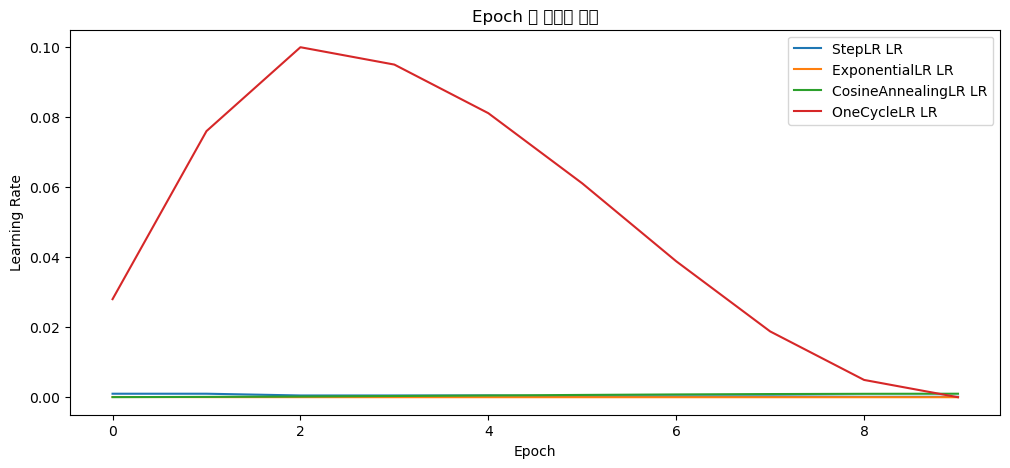

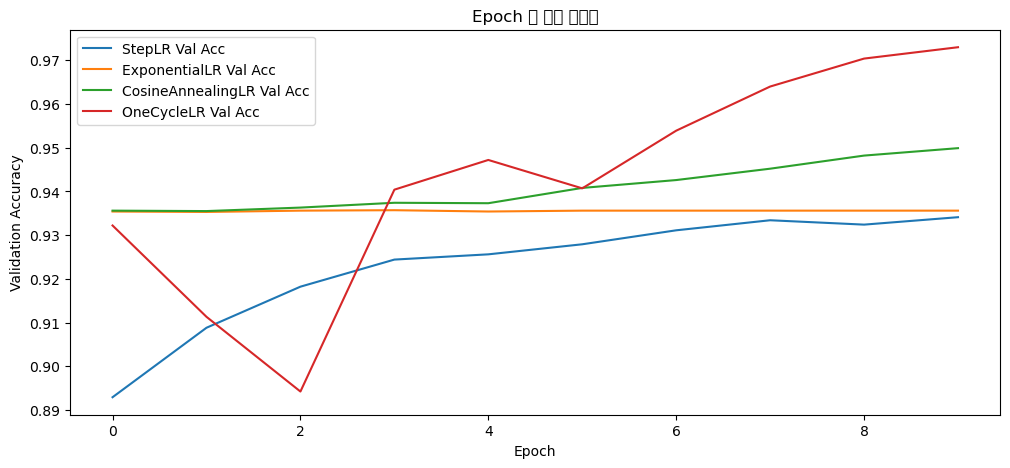

In [192]:
# 4) 시각화
plt.figure(figsize=(12,5))
for name, (lrs, accs) in result.items():
    plt.plot(lrs, label=f"{name} LR")
plt.title("Epoch 별 학습률 변화")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for name, (lrs, accs) in result.items():
    plt.plot(accs, label=f"{name} Val Acc")
plt.title("Epoch 별 검증 정확도")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=1e-3, momentum=0.9),
    # 예를 들어
    "Adam": lambda params: optim.Adam(params, lr=1e-3),
    "RAdam": lambda params: optim.RAdam(params, lr=1e-3)
}
params---> 함수 호출 파트

scheduler = {
    'StepLR'           : lambda opt: StepLR(opt, step_size=3, gamma=0.5),
    'ExponentialLR'    : lambda opt: ExponentialLR(opt, gamma=0.5),
    'CosineAnnealingLR': lambda opt: CosineAnnealingLR(opt, T_max=num_epoch, eta_min=1e-3),
    'OneCycleLR'       : OneCycleLR     # ← 람다가 아니라 클래스 참조
}
opt---> 함수 호출 파트